## Recurrent neural networks for sequence classification with TensorFlow Eager
----

Hello everyone! In this tutorial, we are going to build a recurrent neural network for sentiment analysis on IMDB movie reviews. I've chosen this dataset as it is small in size and very easy to download by any of you so that there's no bottleneck in data acquisition :).

The main aim of this tutorial is not focused on teaching you how to build a simple RNN, but rather on how to build a RNN that gives you more flexibility in the model development (e.g. use a new RNN cell that is not currently available in Keras, easier access to the unrolled outputs of the RNN, read data in batches from disk). My hope is to be able to give you a glimpse on how you can go on and build your own models, no matter how complicated they might get, in whatever area might be of interest to you.

**This tutorial will thus be divided in the following steps:**
> * *Download the **raw data** and transfer it to **TFRecords** (the default TensorFlow file format).*
* *Prepare a **dataset Iterator** that reads data in batches, from disk, and automatically pads the input data of  variable length to the maximum size within a batch.*
* *Build a **word-level RNN** model with both **LSTM** and **UGRNN cells**.*
* *Save trained models*
* *Compare the performance of both cells on the test dataset.*
* *Test the network on a new review*
If you would like to add anything to this tutorial please let me know. Also, I am happy to hear any suggestions you have for improvement.

In [3]:
###################################################
# Import here useful libraries
###################################################
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import functions to write and parse TFRecords
from data_utils import imdb2tfrecords
from data_utils import parse_imdb_sequence

# Import TensorFlow and TensorFlow Eager
import tensorflow as tf
import tensorflow.contrib.eager as tfe

# Import pandas for data processing and pickle for data reading
import matplotlib.pyplot as plt
import pandas as pd
import pickle

%matplotlib inline

In [2]:
# Enable eager mode. Once activated it cannot be reversed! Run just once.
tfe.enable_eager_execution(device_policy=tfe.DEVICE_PLACEMENT_SILENT)

### Download data and transfer it to TFRecords
----

Alternatively, if you clone this repository, you will automatically download the parsed data to TFRecords, so feel free to skip this step. If you would like to test this RNN network with a new dataset, please have a look at the *imdb2tfrecords* or *parse_imdb_sequence* in the *data_utils.py* script in order to understand how you could parse your new data to TFRecords. I really recommend using this file format as it makes is very easy to work with very large datasets, without being constrained to your RAM capabilities.

To download this dataset, simply run in the terminal:
> **chmod o+x datasets/get_imdb_dataset.sh**

> **datasets/get_imdb_dataset.sh**

After downloading the dataset, simply run the imdb2tfrecords function. This function will parse each review into a list of word indices. At the end of this processing, each tfrecord will be composed of a *sequence of word indexes*, the *target (0 for negative sentiment or 1 for positive sentiment)* and the *sequence length* of the review.

In [4]:
# Function to process the raw data to TFRecords, indexing each word in the review to an index.
#imdb2tfrecords(path_data='datasets/aclImdb/', min_word_frequency=5, max_words_review=700)

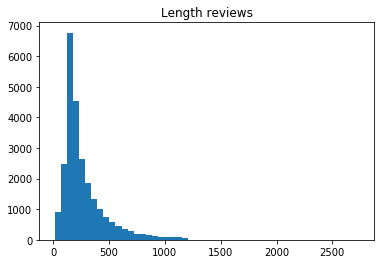

In [4]:
length_reviews = pickle.load(open('datasets/aclImdb/length_reviews.pkl', 'rb'))
pd.DataFrame(length_reviews, columns=['Length reviews']).hist(bins=50);
plt.grid(False);

Dataset info:
* 25000 reviews in the train dataset (12500 positive and 125000 negative)
* 25000 reviews in the test dataset (12500 positive and 125000 negative)

Here is an example of a positive review:
Rented the movie as a joke. My friends and I had so much fun laughing at it that I went and found a used copy and bought it for myself. Now when all my friends are looking for a funny movie I give them Sasquatch Hunters. It needs to be said though there is a rule that was made that made the movie that much better. No talking is allowed while the movie is on unless the words are Sasquatch repeated in a chant. I loved the credit at the end of the movie as well. "Thanks for the Jeep, Tom!" Whoever Tom is I say thank you because without your Jeep the movie may not have been made. In short a great movie if you are looking for something to laugh at. If you want a good movie maybe look for something else but if you don't mind a laugh at the expense of a man in a monkey suit grab yourself a copy.


And here is an example of a negative review:
The Good: I liked this movie because it was the first horror movie I've seen in a long time that actually scared me. The acting wasn't too bad, and the "Cupid" killer was believable and disturbing. The Bad: The story line and plot of this movie is incredibly weak. There just wasn't much to it. The ways the killer killed his victims was very horrifying and disgusting. I do not recommend this movie to anyone who can not handle gore. Overall: A good scare, but a bad story. 



### RNN model for sequence classification, compatible with Eager API 
----
![img](tutorials_graphics/ImdbLSTM.png)

In [5]:
class RNNModel(tf.keras.Model):
    def __init__(self, embedding_size=100, cell_size=64, dense_size=128, 
                 num_classes=2, vocabulary_size=None, rnn_cell='lstm'):
        '''
        Initializing the parameters of the model.
        '''
        super(RNNModel, self).__init__()
        
        # Weights initializer function
        w_initializer = tf.contrib.layers.xavier_initializer()
        
        # Biases initializer function
        b_initializer = tf.zeros_initializer()
        
        # Initialize weights for word embeddings 
        self.embeddings = tf.keras.layers.Embedding(vocabulary_size, embedding_size, 
                                                    embeddings_initializer=w_initializer)
        
        # Dense layer initialization
        self.dense_layer = tf.keras.layers.Dense(dense_size, activation=tf.nn.relu, 
                                                 kernel_initializer=w_initializer, 
                                                 bias_initializer=b_initializer)
        
        # Predictions layer initialization
        self.pred_layer = tf.keras.layers.Dense(num_classes, activation=None, 
                                                kernel_initializer=w_initializer, 
                                                bias_initializer=b_initializer)
        
        # Basic LSTM cell
        if rnn_cell=='lstm':
            self.rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(cell_size)
        # Else UGRNN cell
        else:
            self.rnn_cell = tf.contrib.rnn.UGRNNCell(cell_size)
        
    def predict(self, X, seq_length, is_training):
        '''
        Predicts the probability of each class, based on the input sample.

        Args:
            X: 3D tensor of shape (batch_size, time_steps)
            seq_length: the length of each sequence in the batch, size (batch_size,)
        '''
        # Get the number of samples within a batch
        num_samples = tf.shape(X)[0]

        # Initialize LSTM cell state with zeros
        state = self.rnn_cell.zero_state(num_samples, dtype=tf.float32)
        
        # Get the embedding of each word in the sequence
        embedded_words = self.embeddings(X)
        
        # Unstack the embeddings
        unstacked_embeddings = tf.unstack(embedded_words, axis=1)
        
        # Iterate through each timestep and append the predictions
        outputs = []
        for input_step in unstacked_embeddings:
            output, state = self.rnn_cell(input_step, state)
            outputs.append(output)
            
        # Stack outputs to (batch_size, time_steps, cell_size)
        outputs = tf.stack(outputs, axis=1)
        
        # Extract the output of the last time step, of each sample
        final_output = tf.gather_nd(outputs, tf.stack([tf.range(num_samples), 
                                                       tf.cast(seq_length-1, tf.int32)], axis=1))
        
        # Add dropout for regularization
        dropped_output = tf.layers.dropout(final_output, rate=0.3, training=is_training)
        
        # Pass the last cell state through a dense layer (ReLU activation)
        dense = self.dense_layer(dropped_output)
        
        # Compute the unnormalized log probabilities
        logits = self.pred_layer(dense)
        
        return logits

### Define a loss function, optimizer and gradient function
----

In [6]:
# Define loss function
def loss(model, X, seq_length, y, is_training):
    logits = model.predict(X, seq_length, is_training)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

In [7]:
# Define function to compute gradients
def grad(model, X, seq_length, y, is_training):
    with tfe.GradientTape() as tape:
        loss_value = loss(model, X, seq_length, y, is_training)
    return tape.gradient(loss_value, model.variables)

### Define function for model training with early stopping
----


In [8]:
def train_model(model, train_dataset, test_dataset, device='cpu:0', num_epochs=500,
                early_stopping_rounds=5, best_acc=-1, verbose=True):
    
    # Initialize classes to compute the mean accuracy of train and test
    train_acc = tfe.metrics.Accuracy('train_acc')
    test_acc = tfe.metrics.Accuracy('test_acc')
    
    # Create dictionary to store training and dev results
    history = {}
    history['train_acc'], history['test_acc'] = [], []
    
    # Begin training
    with tf.device(device):
        for i in range(num_epochs):
            # Batch gradient descent on entire dataset
            for X, y, seq_length in tfe.Iterator(train_dataset):
                grads = grad(model, X, seq_length, y, True)
                optimizer.apply_gradients(zip(grads, model.variables))   

            # Check accuracy train dataset
            for X, y, seq_length in tfe.Iterator(train_dataset):
                logits = model.predict(X, seq_length, False)
                preds = tf.argmax(logits, axis=1)
                train_acc(preds, y)
            history['train_acc'].append(train_acc.result().numpy())
            # Reset metrics
            train_acc.init_variables()

            # Check accuracy test dataset
            for X, y, seq_length in tfe.Iterator(test_dataset):
                logits = model.predict(X, seq_length, False)
                preds = tf.argmax(logits, axis=1)
                test_acc(preds, y)
            history['test_acc'].append(test_acc.result().numpy())
            # Reset metrics
            test_acc.init_variables()
            
            if verbose:
                # Print train and test accuracies
                print('Train accuracy at epoch %d: ' %(i+1), history['train_acc'][-1])
                print('Test accuracy at epoch %d: ' %(i+1), history['test_acc'][-1])

            # Check for early stopping
            if history['test_acc'][-1]>best_acc:
                best_acc = history['test_acc'][-1]
                count = early_stopping_rounds
            else:
                count -= 1
            if count==0:
                return model, history
                break

## Word-Level RNN
### Creating a train and test dataset iterator
----    

In [9]:
train_dataset = tf.data.TFRecordDataset('datasets/aclImdb/train.tfrecords')
train_dataset = train_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
train_dataset = train_dataset.padded_batch(512, padded_shapes=([None],[],[]))

In [10]:
test_dataset = tf.data.TFRecordDataset('datasets/aclImdb/test.tfrecords')
test_dataset = test_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
test_dataset = test_dataset.padded_batch(512, padded_shapes=([None],[],[]))

In [11]:
# Read the word vocabulary
word2idx = pickle.load(open('datasets/aclImdb/word2idx.pkl', 'rb'))

### Model training with simple LSTM cells
----

In [12]:
# Select here the device. Use the GPU if available.
device = 'gpu:0' if tfe.num_gpus()>0 else 'cpu:0'

In [13]:
# Train model with early stopping
with tf.device(device):
    # Initialize optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
    model = RNNModel(vocabulary_size=len(word2idx))

trained_model, lstm_history = train_model(model, train_dataset, test_dataset, device=device)

Train accuracy at epoch 1:  0.71824
Test accuracy at epoch 1:  0.683
Train accuracy at epoch 2:  0.7492
Test accuracy at epoch 2:  0.71352
Train accuracy at epoch 3:  0.87256
Test accuracy at epoch 3:  0.82636
Train accuracy at epoch 4:  0.91844
Test accuracy at epoch 4:  0.85184
Train accuracy at epoch 5:  0.93764
Test accuracy at epoch 5:  0.86672
Train accuracy at epoch 6:  0.95788
Test accuracy at epoch 6:  0.87312
Train accuracy at epoch 7:  0.97152
Test accuracy at epoch 7:  0.88316
Train accuracy at epoch 8:  0.98044
Test accuracy at epoch 8:  0.87912
Train accuracy at epoch 9:  0.98612
Test accuracy at epoch 9:  0.87732
Train accuracy at epoch 10:  0.98924
Test accuracy at epoch 10:  0.86532
Train accuracy at epoch 11:  0.99388
Test accuracy at epoch 11:  0.86896
Train accuracy at epoch 12:  0.9958
Test accuracy at epoch 12:  0.86472


In [14]:
# Save model
checkpoint_directory = 'models_checkpoints/ImdbRNN/SimpleLSTM/'
tfe.Saver(trained_model.variables).save(checkpoint_directory, global_step=0)

'models_checkpoints/ImdbRNN/SimpleLSTM/-0'

### Model training with UGRNN cells 
---

In [15]:
# Train model with early stopping
with tf.device(device):
    tf.reset_default_graph()
    # Initialize optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
    model = RNNModel(vocabulary_size=len(word2idx), rnn_cell='ugrnn')

trained_model, ugrnn_history = train_model(model, train_dataset, test_dataset, device=device)

Train accuracy at epoch 1:  0.73092
Test accuracy at epoch 1:  0.6944
Train accuracy at epoch 2:  0.81796
Test accuracy at epoch 2:  0.78444
Train accuracy at epoch 3:  0.902
Test accuracy at epoch 3:  0.84984
Train accuracy at epoch 4:  0.93784
Test accuracy at epoch 4:  0.8674
Train accuracy at epoch 5:  0.95764
Test accuracy at epoch 5:  0.87712
Train accuracy at epoch 6:  0.97272
Test accuracy at epoch 6:  0.87968
Train accuracy at epoch 7:  0.98044
Test accuracy at epoch 7:  0.87392
Train accuracy at epoch 8:  0.98872
Test accuracy at epoch 8:  0.86584
Train accuracy at epoch 9:  0.98796
Test accuracy at epoch 9:  0.85288
Train accuracy at epoch 10:  0.98976
Test accuracy at epoch 10:  0.86668
Train accuracy at epoch 11:  0.99624
Test accuracy at epoch 11:  0.86488


In [21]:
# Save model
checkpoint_directory = 'models_checkpoints/ImdbRNN/UGRNN/'
tfe.Saver(trained_model.variables).save(checkpoint_directory, global_step=0)

'models_checkpoints/ImdbRNN/UGRNN/-0'

### Performance comparison
---

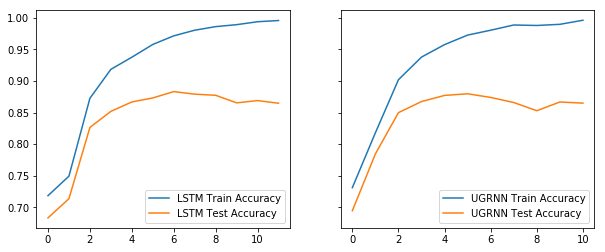

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_history['train_acc'])), lstm_history['train_acc'], label='LSTM Train Accuracy');
ax1.plot(range(len(lstm_history['test_acc'])), lstm_history['test_acc'], label='LSTM Test Accuracy');
ax2.plot(range(len(ugrnn_history['train_acc'])), ugrnn_history['train_acc'], label='UGRNN Train Accuracy');
ax2.plot(range(len(ugrnn_history['test_acc'])), ugrnn_history['test_acc'], label='UGRNN Test Accuracy');
ax1.legend();
ax2.legend();

#### Time testing

In [18]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
X, y, seq_length = tfe.Iterator(train_dataset).get_next()
dummy_lstm = RNNModel(vocabulary_size=len(word2idx))
dummy_ugrnn = RNNModel(vocabulary_size=len(word2idx), rnn_cell='ugrnn')

#### LSTM time performance

In [19]:
%%timeit range(5)
with tf.device(device):
    grads = grad(dummy_lstm, X, seq_length, y, True)
    optimizer.apply_gradients(zip(grads, dummy_lstm.variables))   

998 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### UGRNN time performance

In [20]:
%%timeit range(5)
with tf.device(device):
    grads = grad(dummy_ugrnn, X, seq_length, y, True)
    optimizer.apply_gradients(zip(grads, dummy_ugrnn.variables))   

1.08 s ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Test network on new review
---

In [15]:
from nltk.tokenize import word_tokenize
import re

In [36]:
review = "Deadpool is the movie equivalent of the parents going out of town for the weekend while the high school throws a party, gets drunk, has sex in the backseat of the car and then pukes in the driveway, and in a good way. It appears as though Fox has turned a blind eye while director Tim Miller, star Ryan Reynolds and screenwriters Rhett Reese and Paul Wernick run amok, having the time of their lives and thankfully bringing us along for the ride. Deadpool stars Reynolds as the mentally unhinged hit-man, Wade Wilson. This is not a story where the upstanding protagonist is flung into the throes of an extraordinary situation. No, this superhero tale about an unstable bad guy who gets superpowers, and it's refreshing as hell. Without getting into spoiler territory, this is a revenge movie masquerading as a superhero origin story. Following what may be the most creative opening credits sequence in the history of film, we are flung mercilessly into the maelstrom of Deadpool. Once the light turns green, all bets are off as Deadpool takes us through his journey, explaining his origin, his revenge mission and even his unconventional, if at times endearing relationship with his girlfriend, Vanessa, who may be as, or more, damaged than Wade himself. There really isn't anything bad I can say about the movie, except that I was sad when it ended, but they were able to cram just enough crazy into this 107 minutes that it just works perfectly. I plan on watching movie at least three more times."

In [37]:
review = re.sub(r'<[^>]+>', ' ', review)
review = word_tokenize(review)
review = [word2idx[word] if word in list(word2idx.keys()) else 
          word2idx['Unknown_token'] for word in review]
indexed_review = review + [word2idx['End_token']]
seq_length = len(indexed_review)

In [43]:
with tf.device(device):
    review = tf.reshape(tf.constant(indexed_review), (1,-1))
    seq_length = tf.reshape(tf.constant(seq_length), (1,))
    logits = model.predict(review, seq_length, False)
   